# Spectral integration per bands 
- 0-0.5, 0.5,2.5, 2.5-
- for velocity and acceleration

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon

import drifters.utils as ut
import pynsitu as pin
from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams.update({"font.size": 16})

import drifters.utils as ut
import pynsitu as pin

from GDP_lib import noise_traj, negpos_spectra

In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster()
    w = cluster.scale(jobs=2)  # 2 not enough for lon, lat, year, binning
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.185:8787/status,
Dashboard: http://10.148.0.185:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.185:39123,Workers: 0
Dashboard: http://10.148.0.185:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# LOAD

In [4]:
root_dir = "/home1/datawork/mdemol/GDP"
"""
key2 = ""
zarr_argos = os.path.join(root_dir, "argos_geospectra_2" + key2 + ".zarr")
zarr_gps = os.path.join(root_dir, "gps_geospectra_2" + key2 + ".zarr")
dsg = xr.open_zarr(zarr_gps).persist()
dsa = xr.open_zarr(zarr_argos).persist()
"""

key2 = "_corrected"
zarr_argos = os.path.join(root_dir, "argos_geospectra_2" + key2 + ".zarr")
zarr_gps = os.path.join(root_dir, "gps_geospectra_2" + key2 + ".zarr")
dsgc = xr.open_zarr(zarr_gps)
dsac = xr.open_zarr(zarr_argos)

neg, pos = negpos_spectra(dsgc)
dsgc = (neg + pos).persist()
neg, pos = negpos_spectra(dsac)
dsac = (neg + pos).persist()

In [4]:
dsgc

<xarray.Dataset>
Dimensions:        (frequency: 720, lat_bins: 90, lon_bins: 180)
Coordinates:
  * frequency      (frequency) float64 -0.0 0.01667 0.03333 ... 11.97 11.98
  * lat_bins       (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon_bins       (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
Data variables: (12/13)
    E_aen          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_avxy         (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_axy          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_err_lonlat   (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_err_lonlatm  (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_err_vevn     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    ...             ...
    E_venw2        (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_vxy          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_vxydiff      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_vxyw2        (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_xy           (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    nb_geobins     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(180, 90, 720), meta=np.ndarray>

_______
# Velocity

Text(0.5, 1.0, 'Argos')

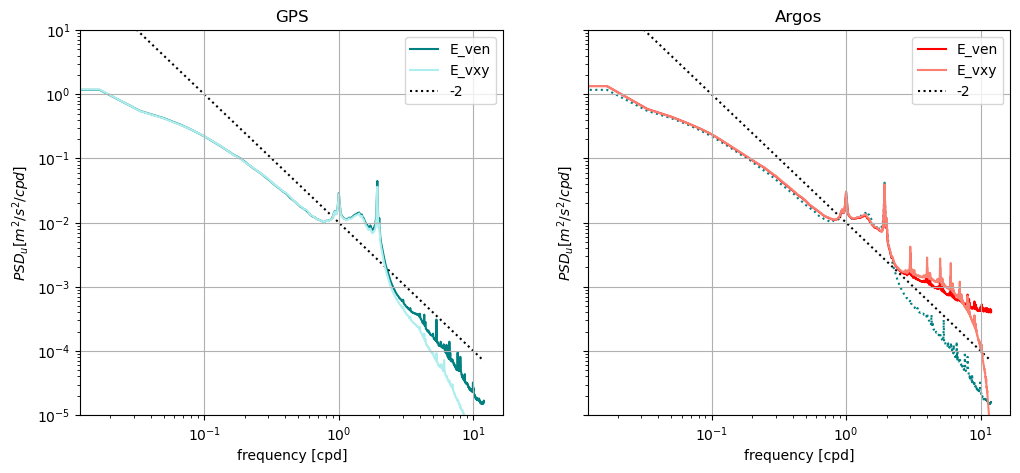

In [5]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
ax = ax.flatten()

dsgc.E_ven.mean(["lon_bins", "lat_bins"]).plot(
    label="E_ven", color="teal", ax=ax[0], zorder=1
)
dsgc.E_vxy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_vxy", color="paleturquoise", ax=ax[0], zorder=1
)

dsgc.E_ven.mean(["lon_bins", "lat_bins"]).plot(ls=":", color="teal", ax=ax[1], zorder=1)
dsac.E_ven.mean(["lon_bins", "lat_bins"]).plot(
    label="E_ven", color="red", ax=ax[1], zorder=1
)
dsac.E_vxy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_vxy", color="salmon", ax=ax[1], zorder=1
)

for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")
    a.set_xscale("log")
    a.set_yscale("log")
    (1 / dsac.frequency**2 * 1e-2).plot(ax=a, label="-2", ls=":", color="k", zorder=0)
    # (1 / dsac.frequency * 1e-1).plot(ax=a, label="-1", ls=":", color = 'grey')
    a.set_ylim((1e-5, 1e1))
    a.set_ylabel(r"$PSD_u [m^2/s^2/cpd]$")
    a.legend()

ax[0].set_title("GPS")
ax[1].set_title("Argos")

Text(0.5, 1.0, 'Argos')

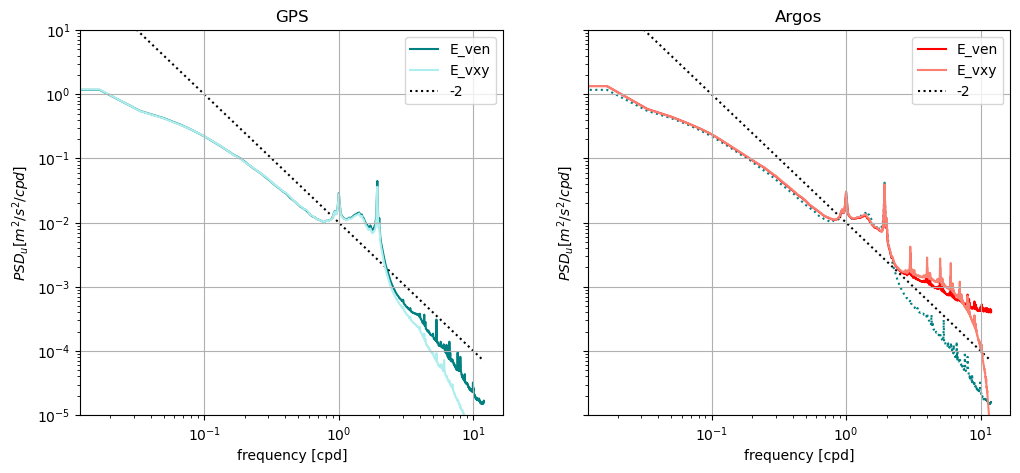

In [8]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
ax = ax.flatten()

dsgc.E_ven.mean(["lon_bins", "lat_bins"]).plot(
    label="E_ven", color="teal", ax=ax[0], zorder=1
)
dsgc.E_vxy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_vxy", color="paleturquoise", ax=ax[0], zorder=1
)

dsgc.E_ven.mean(["lon_bins", "lat_bins"]).plot(ls=":", color="teal", ax=ax[1], zorder=1)
dsac.E_ven.mean(["lon_bins", "lat_bins"]).plot(
    label="E_ven", color="red", ax=ax[1], zorder=1
)
dsac.E_vxy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_vxy", color="salmon", ax=ax[1], zorder=1
)

for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")
    a.set_xscale("log")
    a.set_yscale("log")
    (1 / dsac.frequency**2 * 1e-2).plot(ax=a, label="-2", ls=":", color="k", zorder=0)
    # (1 / dsac.frequency * 1e-1).plot(ax=a, label="-1", ls=":", color = 'grey')
    a.set_ylim((1e-5, 1e1))
    a.set_ylabel(r"$PSD_u [m^2/s^2/cpd]$")
    a.legend()

ax[0].set_title("GPS")
ax[1].set_title("Argos")

In [18]:
fmin = -12
fmax = 0.5
sel = dsgc.where((dsgc.frequency >= fmin) & (dsgc.frequency < fmax), drop=True)

In [19]:
sel

<xarray.Dataset>
Dimensions:        (lon_bins: 180, lat_bins: 90, frequency: 751)
Coordinates:
  * frequency      (frequency) float64 -12.0 -11.98 -11.97 ... 0.4667 0.4833 0.5
  * lat_bins       (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon_bins       (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
Data variables: (12/13)
    E_aen          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_avxy         (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_axy          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_err_lonlat   (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_err_lonlatm  (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_err_vevn     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    ...             ...
    E_venw2        (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxy          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxydiff      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxyw2        (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_xy           (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    nb_geobins     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(180, 90, 751), meta=np.ndarray>

In [85]:
dsgc.mean(["lon_bins", "lat_bins"]).integrate("frequency").compute()

<xarray.Dataset>
Dimensions:        ()
Data variables: (12/13)
    E_aen          float64 2.849e-10
    E_avxy         float64 6.357e-08
    E_axy          float64 3.262e-10
    E_err_lonlat   float64 0.4285
    E_err_lonlatm  float64 2.13e+09
    E_err_vevn     float64 0.0005732
    ...             ...
    E_venw2        float64 3.904e-10
    E_vxy          float64 0.1154
    E_vxydiff      float64 0.1234
    E_vxyw2        float64 2.746e-10
    E_xy           float64 1.109e+13
    nb_geobins     float64 3.158

In [16]:
1.22**2

1.4884

In [31]:
dsgc

<xarray.Dataset>
Dimensions:        (frequency: 720, lat_bins: 90, lon_bins: 180)
Coordinates:
  * frequency      (frequency) float64 -0.0 0.01667 0.03333 ... 11.97 11.98
  * lat_bins       (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon_bins       (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
Data variables: (12/13)
    E_aen          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_avxy         (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_axy          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_err_lonlat   (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_err_lonlatm  (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_err_vevn     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    ...             ...
    E_venw2        (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_vxy          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_vxydiff      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_vxyw2        (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    E_xy           (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 1), meta=np.ndarray>
    nb_geobins     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(180, 90, 720), meta=np.ndarray>

In [7]:
def var_per_band(ds, fmin, fmax):
    return ds.where(
        (ds.frequency >= fmin) & (dsgc.frequency < fmax), drop=True
    ).integrate(
        "frequency"
    )  # |(ds.frequency<= -fmin) & (dsgc.frequency> -fmax), drop=True).integrate('frequency')


BF = var_per_band(dsgc.mean(["lon_bins", "lat_bins"]), 0, 0.5)["E_ven"]
HF = var_per_band(dsgc.mean(["lon_bins", "lat_bins"]), 0.5, 2.5)["E_ven"]
noise = var_per_band(dsgc.mean(["lon_bins", "lat_bins"]), 2.5, 12.5)["E_ven"]

In [11]:
BF = var_per_band(dsgc.mean(["lon_bins", "lat_bins"]), 0, 0.5)[
    ["E_ven", "E_vxy"]
].compute()
HF = var_per_band(dsgc.mean(["lon_bins", "lat_bins"]), 0.5, 2.5)[
    ["E_ven", "E_vxy"]
].compute()
noise = var_per_band(dsgc.mean(["lon_bins", "lat_bins"]), 2.5, 12.5)[
    ["E_ven", "E_vxy"]
].compute()
# tot = BF+HF+noise
tot = (
    dsgc.mean(["lon_bins", "lat_bins"])[["E_ven", "E_vxy"]]
    .integrate("frequency")
    .compute()
)

print(
    "For GPS :\n"
    + f"Nrj total : ven {float(tot.E_ven)} vxy {float(tot.E_vxy)}\n"
    + f"Nrj between 0 and 0.5 cpd : ven {float(BF.E_ven/tot.E_ven*100)}%, vxy {float(BF.E_vxy/tot.E_vxy*100)} % \n"
    + f"Nrj between 0 and 0.5 cpd : ven {float(BF.E_ven)}, vxy {float(BF.E_vxy)}  \n"
    + f"Nrj between 0.5 and 2.5 cpd : ven {float(HF.E_ven/tot.E_ven*100)}%, vxy {float(HF.E_vxy/tot.E_vxy*100)} % \n"
    + f"Nrj between 0.5 and 2.5 cpd : ven {float(HF.E_ven)}, vxy {float(HF.E_vxy)}  \n"
    + f"Nrj between 2.5 and 12 cpd : ven {float(noise.E_ven/tot.E_ven*100)}%, vxy {float(noise.E_vxy/tot.E_vxy*100)} % \n"
    + f"Nrj between 2.5 and 12 cpd : ven {float(noise.E_ven)}, vxy {float(noise.E_vxy)} \n"
)

BF = var_per_band(dsac.mean(["lon_bins", "lat_bins"]), 0, 0.5)[
    ["E_ven", "E_vxy"]
].compute()
HF = var_per_band(dsac.mean(["lon_bins", "lat_bins"]), 0.5, 2.5)[
    ["E_ven", "E_vxy"]
].compute()
noise = var_per_band(dsac.mean(["lon_bins", "lat_bins"]), 2.5, 12.5)[
    ["E_ven", "E_vxy"]
].compute()
# tot = BF+HF+noise
tot = (
    dsac.mean(["lon_bins", "lat_bins"])[["E_ven", "E_vxy"]]
    .integrate("frequency")
    .compute()
)

print(
    "For ARgos :\n"
    + f"Nrj total : ven {float(tot.E_ven)} vxy {float(tot.E_vxy)}\n"
    + f"Nrj between 0 and 0.5 cpd : ven {float(BF.E_ven/tot.E_ven*100)}%, vxy {float(BF.E_vxy/tot.E_vxy*100)} % \n"
    + f"Nrj between 0 and 0.5 cpd : ven {float(BF.E_ven)}, vxy {float(BF.E_vxy)}  \n"
    + f"Nrj between 0.5 and 2.5 cpd : ven {float(HF.E_ven/tot.E_ven*100)}%, vxy {float(HF.E_vxy/tot.E_vxy*100)} % \n"
    + f"Nrj between 0.5 and 2.5 cpd : ven {float(HF.E_ven)}, vxy {float(HF.E_vxy)}  \n"
    + f"Nrj between 2.5 and 12 cpd : ven {float(noise.E_ven/tot.E_ven*100)}%, vxy {float(noise.E_vxy/tot.E_vxy*100)} % \n"
    + f"Nrj between 2.5 and 12 cpd : ven {float(noise.E_ven)}, vxy {float(noise.E_vxy)}  \n"
)

For GPS :
Nrj total : ven 0.11632544973237607 vxy 0.11541137985967058
Nrj between 0 and 0.5 cpd : ven 80.99754100318809%, vxy 82.28922037063795 % 
Nrj between 0 and 0.5 cpd : ven 0.09422075384412426, vxy 0.09497112470551838  
Nrj between 0.5 and 2.5 cpd : ven 17.483157277587473%, vxy 16.64053436371384 % 
Nrj between 0.5 and 2.5 cpd : ven 0.020337361330572266, vxy 0.019205070325184797  
Nrj between 2.5 and 12 cpd : ven 1.22439602654324%, vxy 0.7744986683620952 % 
Nrj between 2.5 and 12 cpd : ven 0.0014242841843817669, vxy 0.0008938596001514681 

For ARgos :
Nrj total : ven 0.1321885823286915 vxy 0.13273956519963076
Nrj between 0 and 0.5 cpd : ven 79.0955413532917%, vxy 79.03628952124664 % 
Nrj between 0 and 0.5 cpd : ven 0.10455527480012022, vxy 0.10491242706042413  
Nrj between 0.5 and 2.5 cpd : ven 15.192745742336648%, vxy 15.468012021433402 % 
Nrj between 0.5 and 2.5 cpd : ven 0.02008307521359745, vxy 0.020532171902277314  
Nrj between 2.5 and 12 cpd : ven 5.4055660396353815%, vxy 5.

_______
# Acceleration

Text(0.5, 1.0, 'Argos')

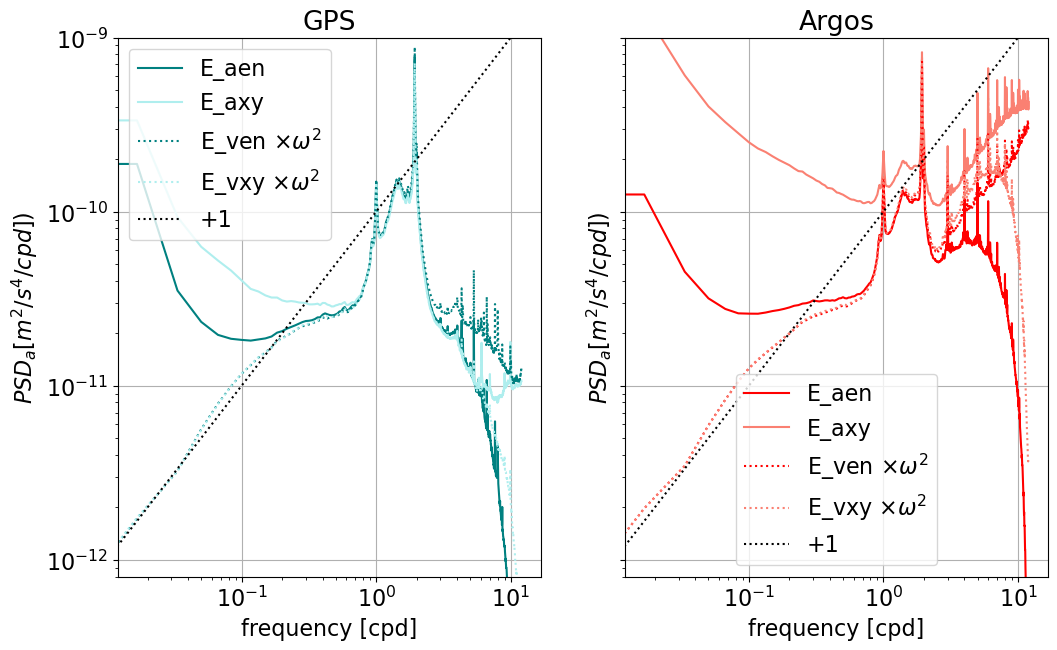

In [8]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 7))
ax = ax.flatten()

dsgc.E_aen.mean(["lon_bins", "lat_bins"]).plot(label="E_aen", color="teal", ax=ax[0])
dsgc.E_axy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_axy", color="paleturquoise", ax=ax[0]
)
# dsgc.E_avxy.mean(["lon_bins", "lat_bins"]).plot(label="E_avxy", color="b", ax=ax[0])
dsgc.E_venw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_ven $ \times \omega^2$", color="teal", ls=":", ax=ax[0]
)
dsgc.E_vxyw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_vxy $ \times \omega^2$", color="paleturquoise", ls=":", ax=ax[0]
)

dsac.E_aen.mean(["lon_bins", "lat_bins"]).plot(label="E_aen", color="red", ax=ax[1])
dsac.E_axy.mean(["lon_bins", "lat_bins"]).plot(label="E_axy", color="salmon", ax=ax[1])
# dsac.E_avxy.mean(["lon_bins", "lat_bins"]).plot(label="E_axy", color="teal", ax=ax[1])
dsac.E_venw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_ven $ \times \omega^2$", color="red", ls=":", ax=ax[1]
)
dsac.E_vxyw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_vxy $ \times \omega^2$", color="salmon", ls=":", ax=ax[1]
)

for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")
    a.set_xscale("log")
    a.set_yscale("log")
    (dsac.frequency.isel(frequency=slice(0, 725)) * 1e-10).plot(
        ax=a, label="+1", ls=":", color="k"
    )
    # (dsac.frequency.isel(frequency= slice(0,725))**0 * 1e-10).plot(ax=a, label="+1", ls=":", color='k')
    # (dsac.frequency**4 * 1e-9).plot(ax=a, label="+4", ls="--")
    a.legend()
    a.set_ylim(8 * 1e-13, 1e-9)
    a.set_ylabel(r"$PSD_a [m^2/s^4/cpd]$)")
ax[0].set_title("GPS")
ax[1].set_title("Argos")

Text(0.5, 1.0, 'Argos')

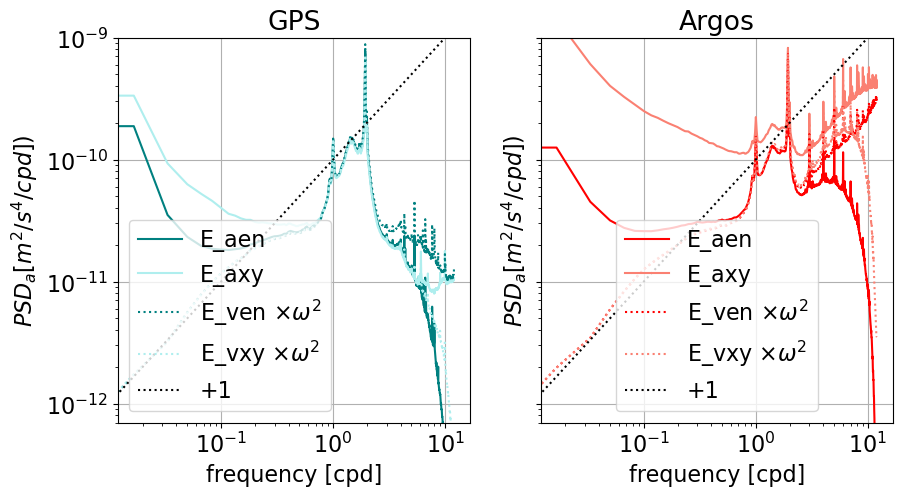

In [6]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax = ax.flatten()

dsgc.E_aen.mean(["lon_bins", "lat_bins"]).plot(label="E_aen", color="teal", ax=ax[0])
dsgc.E_axy.mean(["lon_bins", "lat_bins"]).plot(
    label="E_axy", color="paleturquoise", ax=ax[0]
)
# dsgc.E_avxy.mean(["lon_bins", "lat_bins"]).plot(label="E_avxy", color="b", ax=ax[0])
dsgc.E_venw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_ven $ \times \omega^2$", color="teal", ls=":", ax=ax[0]
)
dsgc.E_vxyw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_vxy $ \times \omega^2$", color="paleturquoise", ls=":", ax=ax[0]
)

dsac.E_aen.mean(["lon_bins", "lat_bins"]).plot(label="E_aen", color="red", ax=ax[1])
dsac.E_axy.mean(["lon_bins", "lat_bins"]).plot(label="E_axy", color="salmon", ax=ax[1])
# dsac.E_avxy.mean(["lon_bins", "lat_bins"]).plot(label="E_axy", color="teal", ax=ax[1])
dsac.E_venw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_ven $ \times \omega^2$", color="red", ls=":", ax=ax[1]
)
dsac.E_vxyw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_vxy $ \times \omega^2$", color="salmon", ls=":", ax=ax[1]
)

for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")
    a.set_xscale("log")
    a.set_yscale("log")
    (dsac.frequency.isel(frequency=slice(0, 725)) * 1e-10).plot(
        ax=a, label="+1", ls=":", color="k"
    )
    # (dsac.frequency.isel(frequency= slice(0,725))**0 * 1e-10).plot(ax=a, label="+1", ls=":", color='k')
    # (dsac.frequency**4 * 1e-9).plot(ax=a, label="+4", ls="--")
    a.legend()
    a.set_ylim(7 * 1e-13, 1e-9)
    a.set_ylabel(r"$PSD_a [m^2/s^4/cpd]$)")
ax[0].set_title("GPS")
ax[1].set_title("Argos")

In [38]:
dsgc.mean(["lon_bins", "lat_bins"]).E_aen.integrate("frequency").compute()

<xarray.DataArray 'E_aen' ()>
array(2.84902964e-10)

In [10]:
BF = var_per_band(dsgc.mean(["lon_bins", "lat_bins"]), 0, 0.5)[
    ["E_aen", "E_axy"]
].compute()
HF = var_per_band(dsgc.mean(["lon_bins", "lat_bins"]), 0.5, 2.5)[
    ["E_aen", "E_axy"]
].compute()
noise = var_per_band(dsgc.mean(["lon_bins", "lat_bins"]), 2.5, 12.5)[
    ["E_aen", "E_axy"]
].compute()
# tot = BF+HF+noise
tot = (
    dsgc.mean(["lon_bins", "lat_bins"])[["E_aen", "E_axy"]]
    .integrate("frequency")
    .compute()
)

print(
    "For GPS :\n"
    + f"Nrj total : aen {float(tot.E_aen)} axy {float(tot.E_axy)}\n"
    + f"Nrj between 0 and 0.5 cpd : aen {float(BF.E_aen/tot.E_aen*100)}%, axy {float(BF.E_axy/tot.E_axy*100)} % \n"
    + f"Nrj between 0 and 0.5 cpd : aen {float(BF.E_aen)}, axy {float(BF.E_axy)}  \n"
    + f"Nrj between 0.5 and 2.5 cpd : aen {float(HF.E_aen/tot.E_aen*100)}%, axy {float(HF.E_axy/tot.E_axy*100)} % \n"
    + f"Nrj between 0.5 and 2.5 cpd : aen {float(HF.E_aen)}, axy {float(HF.E_axy)}  \n"
    + f"Nrj between 2.5 and 12 cpd : aen {float(noise.E_aen/tot.E_aen*100)}%, axy {float(noise.E_axy/tot.E_axy*100)} % \n"
    + f"Nrj between 2.5 and 12 cpd : aen {float(noise.E_aen)}, axy {float(noise.E_axy)}  \n"
)

BF = var_per_band(dsac.mean(["lon_bins", "lat_bins"]), 0, 0.5)[
    ["E_aen", "E_axy"]
].compute()
HF = var_per_band(dsac.mean(["lon_bins", "lat_bins"]), 0.5, 2.5)[
    ["E_aen", "E_axy"]
].compute()
noise = var_per_band(dsac.mean(["lon_bins", "lat_bins"]), 2.5, 12.5)[
    ["E_aen", "E_axy"]
].compute()
# tot = BF+HF+noise
tot = (
    dsac.mean(["lon_bins", "lat_bins"])[["E_aen", "E_axy"]]
    .integrate("frequency")
    .compute()
)
print(
    "For ARgos :\n"
    + f"Nrj total : aen {float(tot.E_aen)} axy {float(tot.E_axy)}\n"
    + f"Nrj between 0 and 0.5 cpd : aen {float(BF.E_aen/tot.E_aen*100)}%, axy {float(BF.E_axy/tot.E_axy*100)} % \n"
    + f"Nrj between 0 and 0.5 cpd : aen {float(BF.E_aen)}, axy {float(BF.E_axy)}  \n"
    + f"Nrj between 0.5 and 2.5 cpd : aen {float(HF.E_aen/tot.E_aen*100)}%, axy {float(HF.E_axy/tot.E_axy*100)} % \n"
    + f"Nrj between 0.5 and 2.5 cpd : aen {float(HF.E_aen)}, axy {float(HF.E_axy)}  \n"
    + f"Nrj between 2.5 and 12 cpd : aen {float(noise.E_aen/tot.E_aen*100)}%, axy {float(noise.E_axy/tot.E_axy*100)} % \n"
    + f"Nrj between 2.5 and 12 cpd : aen {float(noise.E_aen)}, axy {float(noise.E_axy)}  \n"
)

For GPS :
Nrj total : aen 2.849029636221131e-10 axy 3.261450119132639e-10
Nrj between 0 and 0.5 cpd : aen 6.213225097884774%, axy 8.777788249052632 % 
Nrj between 0 and 0.5 cpd : aen 1.7701662440386655e-11, axy 2.8628318530593783e-11  
Nrj between 0.5 and 2.5 cpd : aen 68.02011375699438%, axy 55.80088754875692 % 
Nrj between 0.5 and 2.5 cpd : aen 1.937913199528096e-10, axy 1.8199181134360026e-10  
Nrj between 2.5 and 12 cpd : aen 25.438280808864768%, axy 35.1276930308251 % 
Nrj between 2.5 and 12 cpd : aen 7.247441591897096e-11, axy 1.1456721862023929e-10  

For ARgos :
Nrj total : aen 5.657750392168437e-10 axy 3.3233863464505565e-09
Nrj between 0 and 0.5 cpd : aen 3.1533424406138337%, axy 4.121957852906263 % 
Nrj between 0 and 0.5 cpd : aen 1.7840824430024295e-11, axy 1.3698858448993325e-10  
Nrj between 0.5 and 2.5 cpd : aen 33.013135870880916%, axy 9.728476653009425 % 
Nrj between 0.5 and 2.5 cpd : aen 1.867800824201864e-10, axy 3.2331486480374535e-10  
Nrj between 2.5 and 12 cpd : 

In [9]:
cluster.close()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min